In [2]:
%matplotlib widget
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [4]:
dataH1 = pd.read_csv("GBPUSD_H1.csv")
dataH1['Time'] = pd.to_datetime(dataH1['Time'])

dataTicks = pd.read_csv("GBPUSD_Ticks.csv")
dataTicks['Time'] = pd.to_datetime(dataTicks['Time'], dayfirst=True)

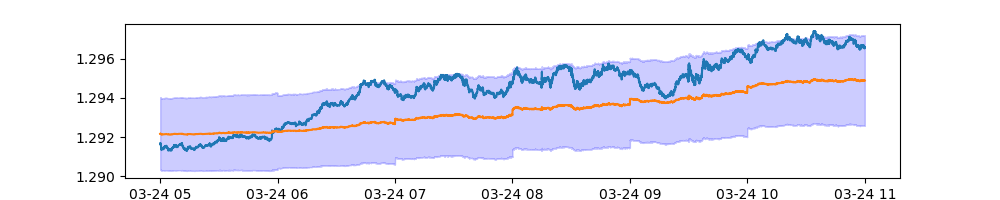

In [100]:
tickPrice = ((dataTicks['Ask']-dataTicks['Bid'])/2 + dataTicks['Bid']).values
tickTimes = dataTicks['Time'].values.astype('datetime64[ms]')

hourClose = dataH1['Close'].values
hourTimes = dataH1['Time'].values

study_start = np.datetime64("2025-03-24T05:00")
study_end = np.datetime64("2025-03-24T11:00")

study_indices = range(np.searchsorted(tickTimes, study_start), np.searchsorted(tickTimes, study_end))

fig, axs = plt.subplots(1,1, figsize=(10,2))
axs.plot(tickTimes[study_indices], tickPrice[study_indices])

window_size = 100

kernel = Matern(length_scale=1.0, nu=1.5)
gpr = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=0, normalize_y=True)

y_preds = np.empty(len(study_indices))
std_preds = np.empty(len(study_indices))

for i in range(len(study_indices)):

    current_time_index = study_indices[i]
    current_time = tickTimes[current_time_index]
    current_hour = current_time.astype('datetime64[h]')
    hour_index = np.searchsorted(hourTimes, current_hour)
    hour_slice = slice(hour_index - window_size, hour_index)
    hour_progress = ((current_time - current_hour)/np.timedelta64(1, 'ms'))/(1000*60*60)

    X = np.vstack((np.arange(window_size)[:, None], [[window_size - 1 + hour_progress]]))
    y = np.vstack((hourClose[hour_slice].reshape(-1, 1), [[tickPrice[current_time_index]]]))

    gpr.fit(X, y)
    y_pred, std = gpr.predict([[window_size - 1 + hour_progress]], return_std=True)

    y_preds[i] = y_pred.item()
    std_preds[i] = std.item()


time_preds = tickTimes[study_indices]
plt.fill_between(time_preds, 
                y_preds - 1.96 * std_preds,
                y_preds + 1.96 * std_preds,
                alpha=0.2, color='blue')
axs.plot(time_preds,y_preds)

In [99]:

time_preds = tickTimes[study_indices]
plt.fill_between(time_preds, 
                y_preds - 1.96 * std_preds,
                y_preds + 1.96 * std_preds,
                alpha=0.2, color='blue')
axs.plot(time_preds,y_preds)


